# Модель CatBoostClassifier

In [1]:
import datetime
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../datasets/data.csv')

In [3]:
df.drop(['Unnamed: 0', 'Probability', 'Column9', 'Column10', 'Column26', 'Column66',
#нулевые
'Column59','Column58','Column60','Column61','Column63','Column65','Column64',
#полностью 1
'Column62',
#дубликаты 53
'Column54','Column55','Column56','Column57'
], axis=1, inplace=True)

In [4]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total (всего пропусков)": na,
        "Percent (процент пропусков)": round(100*na/df.shape[0], 3),
        "Types (тип данных)": df.dtypes
    })
    result = result[result["Total (всего пропусков)"] != 0]
    print(f"Total NA-values (всего пропусков) = {na.sum()}")
    return result.T

In [5]:
check_missings(df)

Total NA-values (всего пропусков) = 580264


,IsCorrect,Column8,Column13,Column14,Column15,Column16,Column17,Column18,Column20,Column21,...,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column67
Total (всего пропусков),40771,35132,130755,1,35,35,35,35,121330,33863,...,1119,1,1120,1,1,1120,1120,1,1,1
Percent (процент пропусков),23.084,19.892,74.033,0.001,0.02,0.02,0.02,0.02,68.696,19.173,...,0.634,0.001,0.634,0.001,0.001,0.634,0.634,0.001,0.001,0.001
Types (тип данных),object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,object,object,object,float64,float64,float64,float64,float64,float64


#### Feature generation & EDA:

In [6]:
#df["ValidationDateTime2"] = pd.to_datetime(df["ValidationDateTime"], errors="coerce")
#df["ValidationDateTime2"] = pd.to_datetime(df["ValidationDateTime"], format='coerce')

#df["ValidationDateTime2"] = pd.to_datetime(df["ValidationDateTime"], errors="coerce")

df["ValidationDateTime2"] = pd.to_datetime(df["ValidationDateTime"], format='mixed')
df["day_of_week"] = df["ValidationDateTime2"].dt.dayofweek
df["hour_of_day"] = df["ValidationDateTime2"].dt.hour
df["month"] = df["ValidationDateTime2"].dt.month
df["quarter"] = df["ValidationDateTime2"].dt.quarter


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176618 entries, 0 to 176617
Data columns (total 54 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   LocationId           176618 non-null  int64         
 1   ProductId            176618 non-null  int64         
 2   ValidationDateTime   176618 non-null  object        
 3   IsCorrect            135847 non-null  object        
 4   Column6              176618 non-null  float64       
 5   Column7              176618 non-null  float64       
 6   Column8              141486 non-null  float64       
 7   Column11             176618 non-null  float64       
 8   Column12             176618 non-null  int64         
 9   Column13             45863 non-null   float64       
 10  Column14             176617 non-null  float64       
 11  Column15             176583 non-null  float64       
 12  Column16             176583 non-null  float64       
 13  Column17      

count    176617.000000
mean         60.364611
std          48.695090
min           0.180000
25%          25.990000
50%          49.990002
75%          74.989998
max        1650.000000
Name: Column53, dtype: float64
Column53
19.990000     5886
69.989998     5844
59.990002     5674
20.990000     5169
29.990000     5010
              ... 
14.580999        1
19.823332        1
19.944998        1
129.830002       1
139.732498       1
Name: count, Length: 35341, dtype: int64


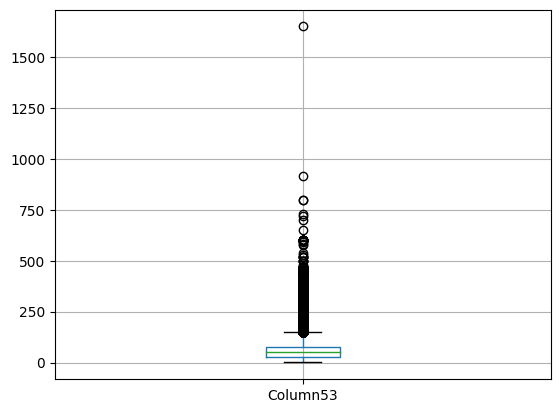

In [8]:
df.boxplot(column=['Column53'])
print(df['Column53'].describe())
print(df['Column53'].value_counts())
#df['Column40'].hist(bins=20)

In [9]:
df['Column29'].hist(bins=20)
df['Column29'].round().value_counts().head(20)

Column29
 0.0     170263
 1.0       5670
 2.0        262
-1.0         37
 3.0         36
 4.0         21
 8.0          6
 9.0          3
 6.0          3
 14.0         1
 5.0          1
 7.0          1
 18.0         1
Name: count, dtype: int64

In [10]:
df['Column8'] = df["Column8"].fillna(0)
df['Column8'] = df['Column8'].apply(lambda x: 1 if x < 1 else 2 if x < 1.7 else 3)
df['Column8']

0         1
1         1
2         1
3         1
4         1
         ..
176613    2
176614    1
176615    2
176616    1
176617    1
Name: Column8, Length: 176618, dtype: int64

In [11]:
df['Column25'] = df['Column25'].apply(lambda x: 1 if x <2.5 else 2)
df['Column25']

0         2
1         2
2         2
3         2
4         2
         ..
176613    2
176614    2
176615    2
176616    2
176617    2
Name: Column25, Length: 176618, dtype: int64

In [12]:
df['Column27'] = df["Column27"].fillna(0)
df['Column27'] = df['Column27'].round()
df['Column27'] = df['Column27'].apply(lambda x: 10 if x >= 10 else 2 if x < 4 else 3)
df['Column27'].value_counts()

Column27
2     119569
3      52466
10      4583
Name: count, dtype: int64

In [13]:
df['Column14'] = df["Column14"].fillna(0)
df['Column14'] = df['Column14'].round()
df['Column14'] = df['Column14'].astype(int)

In [14]:
df['Column15'] = df["Column15"].fillna(0)
df['Column15'] = df['Column15'].round()
df['Column15'] = df['Column15'].astype(int)

In [15]:
df['Column18'] = df["Column18"].fillna(0)
df['Column18'] = df['Column18'].round()
df['Column18'] = df['Column18'].astype(int)

In [16]:
df['Column20'] = df["Column20"].fillna(0)
df['Column20'] = df['Column20'].round()
df['Column20'] = df['Column20'].astype(int)

In [17]:
df['Column21'] = df["Column21"].fillna(0)
df['Column21'] = df['Column21'].round()
df['Column21'] = df['Column21'].astype(int)

In [18]:
df['Column22'] = df["Column22"].fillna(0)
df['Column22'] = df['Column22'].round()
df['Column22'] = df['Column22'].astype(int)

In [19]:
df['Column23'] = df["Column23"].fillna(0)
df['Column23'] = df['Column23'].round()
df['Column23'] = df['Column23'].astype(int)

In [20]:
df['Column6'] = df['Column6'].astype(int)
df['Column7'] = df['Column7'].astype(int)
df['Column8'] = df['Column8'].astype(int)
df['Column14'] = df['Column14'].astype(int)
df['Column19'] = df['Column19'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176618 entries, 0 to 176617
Data columns (total 54 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   LocationId           176618 non-null  int64         
 1   ProductId            176618 non-null  int64         
 2   ValidationDateTime   176618 non-null  object        
 3   IsCorrect            135847 non-null  object        
 4   Column6              176618 non-null  int32         
 5   Column7              176618 non-null  int32         
 6   Column8              176618 non-null  int32         
 7   Column11             176618 non-null  float64       
 8   Column12             176618 non-null  int64         
 9   Column13             45863 non-null   float64       
 10  Column14             176618 non-null  int32         
 11  Column15             176618 non-null  int32         
 12  Column16             176583 non-null  float64       
 13  Column17      

#### Splitting:

In [21]:
train_df = df[~df['IsCorrect'].isna()]

train_df['IsCorrect'] = train_df['IsCorrect'].astype(int)
train_df['Column19'] = train_df['Column19'].astype(int)

test_df = df[df['IsCorrect'].isna()]

test_df.drop('IsCorrect', axis=1, inplace=True)

len(test_df) / len(train_df)

0.3001244046611261

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df, train_size=0.9, random_state=42, stratify=train_df['IsCorrect'])

In [23]:
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['IsCorrect'])

In [24]:
train.select_dtypes(include='object').columns

Index(['ValidationDateTime', 'Column45', 'Column46', 'Column47'], dtype='object')

#### Feature selection:

In [25]:
X = ['LocationId', 'ProductId', 'ValidationDateTime', 'Column6', 'Column7', 'Column8', 'Column11', 'Column12', 'Column14',
        'Column15', 'Column18', 
     'Column19', 
     'Column20',
        'Column21', 'Column22', 'Column23', 'Column24', 'Column25', 'Column27',
        'Column28', 'Column29', 'Column30', 'Column31', 'Column32', 'Column33',
        'Column34', 'Column35', 'Column36', 'Column37', 'Column38', 'Column39',
        'Column40', 'Column41', 'Column42', 'Column43', 'Column44', 'Column45',
        #'Column46', #'Column47', 
     'Column49', 'Column50', 'Column51', 'Column52',
        'Column53', 
#        'Column59', 'Column60', 'Column61', 'Column62', 'Column63', 'Column64',
#        'Column65', 'Column67'
     'day_of_week', 'hour_of_day', 'month', 'quarter'
    ]

cat_features = ['LocationId', 'ProductId',
                'ValidationDateTime',
                'day_of_week', 'hour_of_day', 'month', 'quarter',
                
]

y = ['IsCorrect']

#### Model:

In [26]:
params = {
        'verbose': 100,
        'random_seed': 42,
        'learning_rate': 0.1,
        'eval_metric': 'AUC',
        'cat_features': cat_features, 
        'iterations':2000
}

In [27]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(**params)

In [28]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

0:	test: 0.7959111	best: 0.7959111 (0)	total: 451ms	remaining: 15m
100:	test: 0.9154239	best: 0.9154239 (100)	total: 40.4s	remaining: 12m 39s
200:	test: 0.9203397	best: 0.9203397 (200)	total: 1m 11s	remaining: 10m 38s
300:	test: 0.9220589	best: 0.9220589 (300)	total: 1m 41s	remaining: 9m 31s
400:	test: 0.9227486	best: 0.9227486 (400)	total: 2m 11s	remaining: 8m 42s
500:	test: 0.9232400	best: 0.9232400 (500)	total: 2m 43s	remaining: 8m 7s
600:	test: 0.9237685	best: 0.9237685 (600)	total: 3m 12s	remaining: 7m 27s
700:	test: 0.9241760	best: 0.9241864 (661)	total: 3m 41s	remaining: 6m 50s
800:	test: 0.9245073	best: 0.9245579 (798)	total: 4m 11s	remaining: 6m 16s
900:	test: 0.9249005	best: 0.9249275 (898)	total: 4m 40s	remaining: 5m 42s
1000:	test: 0.9247960	best: 0.9249284 (902)	total: 5m 15s	remaining: 5m 14s
1100:	test: 0.9249557	best: 0.9249557 (1100)	total: 5m 44s	remaining: 4m 41s
1200:	test: 0.9248622	best: 0.9249786 (1108)	total: 6m 14s	remaining: 4m 8s
1300:	test: 0.9250355	best: 0

In [29]:
test['preds'] = model.predict(test[X])

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test['IsCorrect'], test['preds'])

0.8251743741639594

In [31]:
a = model.get_feature_importance(prettified=True)

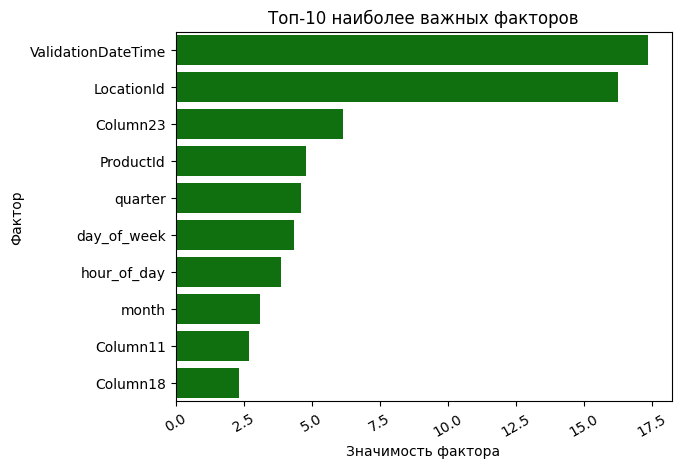

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.barplot(x = a['Importances'], y = a['Feature Id'].head(10), orient = 'h', color = "green")
plt.xlabel('Значимость фактора')
plt.xticks(rotation = 30)
plt.ylabel('Фактор')
plt.title('Топ-10 наиболее важных факторов')
plt.show()

#### ROC_AUC: 0.825

#### Prediction:

In [32]:
test_df

,LocationId,ProductId,ValidationDateTime,Column6,Column7,Column8,Column11,Column12,Column13,Column14,...,Column50,Column51,Column52,Column53,Column67,ValidationDateTime2,day_of_week,hour_of_day,month,quarter
11,63,288606,2023-07-25 14:57:04.000,14,13,1,3.071429,15,NaN,30,...,0.0,1.0,0.0,29.990000,0.0,2023-07-25 14:57:04,1,14,7,3
12,63,288606,2023-08-03 14:58:53.000,2,1,1,1.392857,11,NaN,30,...,1.0,-1.0,0.0,29.990000,0.0,2023-08-03 14:58:53,3,14,8,3
14,63,288783,2023-07-24 14:57:11.000,4,4,1,2.000000,16,NaN,100,...,0.0,1.0,0.0,99.989998,0.0,2023-07-24 14:57:11,0,14,7,3
15,63,288783,2023-08-03 14:57:39.000,0,-1,1,1.964286,18,NaN,100,...,0.0,1.0,0.0,99.989998,0.0,2023-08-03 14:57:39,3,14,8,3
24,63,289136,2023-07-24 14:57:09.000,6,6,1,1.357143,13,NaN,30,...,1.0,0.0,1.0,29.990000,0.0,2023-07-24 14:57:09,0,14,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176604,2950,572875,2023-07-26 15:01:26,19,18,1,3.785714,25,NaN,108,...,0.0,0.0,1.0,107.900002,0.0,2023-07-26 15:01:26,2,15,7,3
176610,2950,574768,2023-07-31 15:07:00,10,9,1,1.321429,4,NaN,26,...,1.0,-1.0,0.0,26.490000,0.0,2023-07-31 15:07:00,0,15,7,3
176615,2950,576631,2023-07-26 15:01:27,1,0,2,3.571429,28,NaN,140,...,0.0,1.0,0.0,139.899994,0.0,2023-07-26 15:01:27,2,15,7,3
176616,2950,576631,2023-07-28 15:04:19,3,2,1,3.607143,28,NaN,140,...,0.0,1.0,0.0,139.684998,0.0,2023-07-28 15:04:19,4,15,7,3


In [33]:
len(test_df)

40771

In [34]:
test_df['CalculatedProbability'] = model.predict_proba(test_df[X])[:, 1]

In [35]:
df_submission = test_df.loc[:, ['LocationId', 'ProductId', 'ValidationDateTime', 'CalculatedProbability']]

df_submission

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
11,63,288606,2023-07-25 14:57:04.000,0.830523
12,63,288606,2023-08-03 14:58:53.000,0.692732
14,63,288783,2023-07-24 14:57:11.000,0.336474
15,63,288783,2023-08-03 14:57:39.000,0.681103
24,63,289136,2023-07-24 14:57:09.000,0.229317
...,...,...,...,...
176604,2950,572875,2023-07-26 15:01:26,0.486380
176610,2950,574768,2023-07-31 15:07:00,0.393879
176615,2950,576631,2023-07-26 15:01:27,0.644335
176616,2950,576631,2023-07-28 15:04:19,0.660453


In [36]:
len(df_submission)

40771

In [37]:
# проверка соответствия размерности: 

len(test_df) == len(df_submission)

True

#### Submition: 

In [38]:
df_submission.to_csv('123456_1.csv', sep=';', index=False)